# 💻 멋진 작사가 만들기

## Step1. 데이터 다운로드

이번 프로젝트에 사용할 데이터는 LMS cloud ~/aiffel/lyricist/data/lyrics 경로에 있는 텍스트 데이터를 사용했다.

## Step2. 데이터 읽어오기

이번 프로젝트에 필요한 라이브러리 호출 및 데이터 정보를 출력한다.

In [1]:
import glob
import os
import re
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 [' There must be some kind of way outta here', 'Said the joker to the thief', "There's too much confusion"]


## Step3. 데이터 정제

자연어 처리에서는 데이터가 알맞은 목적에 맞게 전처리가 돼있지 않은 상태라면, 용도에 맞게 토큰화(Tokenization) 및 정제(cleaning) 과정을 거친다.

 "Time is an illusion. Lunchtime double so!" 이라는 문장이 주어졌을때, 이 문장은 토큰화가 단순하다. 그러나 실제로 토큰화 작업을 수행하다 보면, 예상치 못한 경우가 생긴다.
 
 사용 목적, 의도에 맞게 토큰화 하는 알고리즘을 짜야한다. 이번 프로젝트에서는 여러 특수 기호가 들어가지 않은 단어를 뽑아야 하기 때문에 특수문자, 공백, 대문자를 조절해 단어만 뽑는 알고리즘을 사용한다.
 
 
> - 정제 : 갖고있는 데이터로부터 노이즈 데이터를 제거한다.
> - 정규화 : 의미는 같지만 표현 방법이 다른 단어들을 통합시켜 같은 단어로 만들어준다.

In [2]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence2 = sentence.split(' ')
    if len(sentence2) > 13:
        return 0 
    else:
        sentence = '<start> ' + sentence + ' <end>' # 6
        return sentence

본인은 토큰화 했을 때 토큰의 갯수가 15개를 넘어가지 않는 문장 데이터를 권한다는 조건을 받았기에, <start>, <end>를 제외한 단어의 길이가 13개를 초과하지 않는 조건문을 걸었다.
    
   sentence가 13을 초과할경우 0을 반환하고 그렇지 않으면 sentence를 그대로 반환한다.

In [3]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    if preprocessed_sentence == 0:
        pass
    else:
        corpus.append(preprocessed_sentence)

corpus[:10]

['<start> there must be some kind of way outta here <end>',
 '<start> said the joker to the thief <end>',
 '<start> there s too much confusion <end>',
 '<start> i can t get no relief business men , they drink my wine <end>',
 '<start> plowman dig my earth <end>',
 '<start> none were level on the mind <end>',
 '<start> nobody up at his word <end>',
 '<start> hey , hey no reason to get excited <end>',
 '<start> the thief he kindly spoke <end>',
 '<start> there are many here among us <end>']

이후에 정제된 텍스트 데이터를 모아놓은 preprocessed_sentence의 요소가 "0"(단어의 갯수가 13개 이상인 문장)일경우 지나치고 "0"이 아니라면 corpus에 추가한다.

In [4]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2  62 271 ...   0   0   0]
 [  2 118   6 ...   0   0   0]
 [  2  62  17 ...   0   0   0]
 ...
 [  2  75  45 ...   3   0   0]
 [  2  49   5 ...   0   0   0]
 [  2  13 633 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f95a4dc9e10>


Tensorflow의 Tokenizer와 pad_sequences를 사용해 텍스트 데이터를 토큰화 한다.
본인은 문장을 토큰화 했을때 15개를 초과하지 않으려고 pad_sequences의 maxlen인자로
15의 값을 주었지만, 데이터를 제외시키는게 아닌 슬라이싱의 기능을 가지므로 maxlen을
지워야 했다.

단어장의 크기는 12000이상 이라는 조건이 있으므로, 12000개의 단어를 기억할수 있는 tokenizer를 생성한다.

In [5]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [6]:
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2  62 271  27  94 546  20  86 742  90   3   0   0   0]
[ 62 271  27  94 546  20  86 742  90   3   0   0   0   0]


tensor에서 각각의 마지막 토큰을 잘라내서 입력할 소스 문장을 생성한다.


In [7]:
tensor.shape

(156013, 15)

## Step4. 평가 데이터셋 분리

sklearn 모듈의 train_test_split()함수를 이용해 학습데이터와 테스트 데이터를
8:2 비율로 분리했다.

In [8]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          test_size = 0.2,
                                                          random_state = 7)

In [9]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124810, 14)
Target Train: (124810, 14)


In [10]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## Step5. 인공지능 만들기

실습 내용에서 사용한 모델의 구조는 1개의 Embedding 레이어 2개의 LSTM 레이어, 1개의 Dense레이어로 구성되있다. 각 레이어의 기능은 다음과 같다.

> - Embedding : 인간의 언어(자연어)는 수치화 되있지 않은 데이터기 때문에 바로 모델에 사용할 수 없다. 그래서 자연어 처리에서 특징 추출을 해줘야 하는데 이것이 "언어의 벡터화"이다. 이런 벡터화의 과정을 Word Embedding이라고 한다.
> - LSTM : (Long Short Term Memory)의 약자로 기존의 RNN이 출력과 먼 위치에 있는 정보를 기억할 수 없다는 단점을 보완하여 장/단기 기억을 가능하게 설계한 신경망의 구조이다.
> - Dense : 다층 퍼셉트론 신경망에서 사용되는 레이어로 입력과 출력을 모두 연결해준다.
> - hidden layer : 인공 신경망의 히든 레이어는 입력 레이어와 출력 레이어 사이에 있는 레이어로, 여기서 인공 뉴런은 가중 입력 세트를 받아 활성화 함수를 통해 출력을 생성한다.

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

- embedding size를 256으로 주었다는건, 하나의 token을 256개의 벡터로 바꿔준다는 뜻이다. 나아가 모델 개선하기 파트에서 여러 파라미터 값을 주어 결과를 확인 해보도록 하자.

- hidden size는 은닉 상태의 크기를 정의한다. RNN의 용량을 늘린다고 보면되며, 중소형 모델의 경우 보통 128, 256, 512, 1024등의 값을 갖는다.

In [12]:
for src_sample, tgt_sample in dataset.take(1): break

model(src_sample)
model(src_sample).shape

TensorShape([256, 14, 12001])

In [13]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


- optimizer란 머신러닝 학습에서 실제로 파라미터를 갱신시키는 부분을 의미한다. 이번 실습에서 사용할 optimizer는 Adam이다.
  Adam은 현재 가장 자주 사용되는 optimizer로 폭넓은 딥러닝 아키텍쳐에서 좋은 성능을 보인다고 한다.
  Adam말고도 cs231n에 소개한 Stochastic Gradient Descent(SGD), NAG, RMSProp, AdaGrad 등이 있다.
  
  

- loss(손실 함수)란 컴퓨터는 처음에 랜덤값을 대입해 문제를 풀어본다. 결과와 실제 정답간의 간격 즉, 차이를 최대한 줄이는 방향으로
  값을 대입하게된다. 이 값의 차이를 loss라고 한다. 이 loss를 줄이는 방향으로 학습이 진행된다. loss의 종류에는 
  MSE, MRSE, Binary Crossentropy등이 있으며 이번 실습에 사용할 loss는 Categorical Crossentropy다.


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(dataset, epochs=10)


Epoch 1/10
487/487 [==============================] - 157s 317ms/step - loss: 4.0284
Epoch 2/10
268/487 [===============>..............] - ETA: 1:10 - loss: 3.0834

In [49]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [50]:
generate_text(model, tokenizer, init_sentence = "<start> i love", max_len=20)

'<start> i love you , i m not gonna crack <end> '

## Step5. 인공지능 모델 개선

### (1) hidden_size 값 감소시켜보기

In [49]:
embedding_size = 256
hidden_size = 512
model2 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model2.compile(loss=loss, optimizer=optimizer)
history2 = model2.fit(dataset, epochs=10)

Epoch 1/10
487/487 [==============================] - 72s 143ms/step - loss: 4.4185
Epoch 2/10
487/487 [==============================] - 70s 143ms/step - loss: 3.3409
Epoch 3/10
487/487 [==============================] - 70s 143ms/step - loss: 3.1391
Epoch 4/10
487/487 [==============================] - 70s 143ms/step - loss: 3.0003
Epoch 5/10
487/487 [==============================] - 70s 142ms/step - loss: 2.9041
Epoch 6/10
487/487 [==============================] - 69s 142ms/step - loss: 2.8166
Epoch 7/10
487/487 [==============================] - 70s 143ms/step - loss: 2.7474
Epoch 8/10
487/487 [==============================] - 70s 143ms/step - loss: 2.6843
Epoch 9/10
487/487 [==============================] - 70s 143ms/step - loss: 2.6311
Epoch 10/10
487/487 [==============================] - 70s 143ms/step - loss: 2.5674


In [53]:
embedding_size = 256
hidden_size = 256
model3 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model3.compile(loss=loss, optimizer=optimizer)
history3 = model3.fit(dataset, epochs=10)

Epoch 1/10
487/487 [==============================] - 43s 83ms/step - loss: 4.7102
Epoch 2/10
487/487 [==============================] - 41s 83ms/step - loss: 3.4388
Epoch 3/10
487/487 [==============================] - 41s 83ms/step - loss: 3.3071
Epoch 4/10
487/487 [==============================] - 41s 83ms/step - loss: 3.1462
Epoch 5/10
487/487 [==============================] - 41s 83ms/step - loss: 3.0386
Epoch 6/10
487/487 [==============================] - 41s 83ms/step - loss: 2.9700
Epoch 7/10
487/487 [==============================] - 41s 83ms/step - loss: 2.9009
Epoch 8/10
487/487 [==============================] - 41s 83ms/step - loss: 2.8401
Epoch 9/10
487/487 [==============================] - 41s 84ms/step - loss: 2.7789
Epoch 10/10
487/487 [==============================] - 41s 84ms/step - loss: 2.7238


In [54]:
embedding_size = 256
hidden_size = 128
model4 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model4.compile(loss=loss, optimizer=optimizer)
history4 = model4.fit(dataset, epochs=10)

Epoch 1/10
487/487 [==============================] - 32s 60ms/step - loss: 5.0712
Epoch 2/10
487/487 [==============================] - 30s 61ms/step - loss: 3.5111
Epoch 3/10
487/487 [==============================] - 30s 61ms/step - loss: 3.3391
Epoch 4/10
487/487 [==============================] - 30s 61ms/step - loss: 3.1844
Epoch 5/10
487/487 [==============================] - 30s 61ms/step - loss: 3.0724
Epoch 6/10
487/487 [==============================] - 30s 61ms/step - loss: 2.9993
Epoch 7/10
487/487 [==============================] - 29s 60ms/step - loss: 2.9464
Epoch 8/10
487/487 [==============================] - 29s 60ms/step - loss: 2.8859
Epoch 9/10
487/487 [==============================] - 30s 61ms/step - loss: 2.8444
Epoch 10/10
487/487 [==============================] - 30s 60ms/step - loss: 2.8062


embedding_size를 그대로 두고 hidden_size만 감소 시켰더니 학습 시간을 줄지만 loss값은 대폭 증가했다.

### (2) embedding size 값 변경

imbedding size를 256으로 주었다는건, 하나의 token을 300개의 벡터로 바꿔준다는 뜻이다.

In [14]:
embedding_size = 128
hidden_size = 1024
model5 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model5.compile(loss=loss, optimizer=optimizer)
history5 = model5.fit(dataset, epochs=10)

Epoch 1/10
487/487 [==============================] - 155s 308ms/step - loss: 4.1067
Epoch 2/10
487/487 [==============================] - 153s 313ms/step - loss: 3.1095
Epoch 3/10
487/487 [==============================] - 153s 313ms/step - loss: 2.9488
Epoch 4/10
487/487 [==============================] - 153s 313ms/step - loss: 2.8248
Epoch 5/10
487/487 [==============================] - 153s 313ms/step - loss: 2.7208
Epoch 6/10
487/487 [==============================] - 153s 313ms/step - loss: 2.6295
Epoch 7/10
487/487 [==============================] - 153s 313ms/step - loss: 2.5450
Epoch 8/10
487/487 [==============================] - 152s 312ms/step - loss: 2.4647
Epoch 9/10
487/487 [==============================] - 151s 309ms/step - loss: 2.3891
Epoch 10/10
487/487 [==============================] - 152s 311ms/step - loss: 2.3211


In [15]:
embedding_size = 64
hidden_size = 1024
model6 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model6.compile(loss=loss, optimizer=optimizer)
history6 = model6.fit(dataset, epochs=10)

Epoch 1/10
487/487 [==============================] - 152s 302ms/step - loss: 4.1280
Epoch 2/10
487/487 [==============================] - 149s 305ms/step - loss: 3.1498
Epoch 3/10
487/487 [==============================] - 148s 304ms/step - loss: 2.9924
Epoch 4/10
487/487 [==============================] - 149s 305ms/step - loss: 2.8699
Epoch 5/10
487/487 [==============================] - 148s 304ms/step - loss: 2.7666
Epoch 6/10
487/487 [==============================] - 148s 304ms/step - loss: 2.6898
Epoch 7/10
487/487 [==============================] - 148s 304ms/step - loss: 2.6092
Epoch 8/10
487/487 [==============================] - 148s 304ms/step - loss: 2.5344
Epoch 9/10
487/487 [==============================] - 148s 304ms/step - loss: 2.4647
Epoch 10/10
487/487 [==============================] - 148s 303ms/step - loss: 2.4051


hidden_size를 감소 시켰을때보다 변화율은 크게 없지만 그래도 loss값이 증가함을 볼 수 있었다.

### (3) 그 외의 시도들

In [16]:
embedding_size = 128
hidden_size = 512
model7 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model7.compile(loss=loss, optimizer=optimizer)
history7 = model7.fit(dataset, epochs=10)

Epoch 1/10
487/487 [==============================] - 69s 137ms/step - loss: 4.4768
Epoch 2/10
487/487 [==============================] - 68s 139ms/step - loss: 3.3127
Epoch 3/10
487/487 [==============================] - 68s 139ms/step - loss: 3.1057
Epoch 4/10
487/487 [==============================] - 68s 140ms/step - loss: 2.9909
Epoch 5/10
487/487 [==============================] - 68s 140ms/step - loss: 2.9162
Epoch 6/10
487/487 [==============================] - 68s 140ms/step - loss: 2.8430
Epoch 7/10
487/487 [==============================] - 68s 140ms/step - loss: 2.7738
Epoch 8/10
487/487 [==============================] - 68s 140ms/step - loss: 2.7236
Epoch 9/10
487/487 [==============================] - 68s 139ms/step - loss: 2.6630
Epoch 10/10
487/487 [==============================] - 68s 139ms/step - loss: 2.6199


In [17]:
embedding_size = 64
hidden_size = 512
model8= TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model8.compile(loss=loss, optimizer=optimizer)
history8 = model8.fit(dataset, epochs=10)

Epoch 1/10
487/487 [==============================] - 69s 136ms/step - loss: 4.4924
Epoch 2/10
487/487 [==============================] - 67s 137ms/step - loss: 3.2911
Epoch 3/10
487/487 [==============================] - 67s 137ms/step - loss: 3.1434
Epoch 4/10
487/487 [==============================] - 67s 138ms/step - loss: 3.0350
Epoch 5/10
487/487 [==============================] - 67s 138ms/step - loss: 2.9495
Epoch 6/10
487/487 [==============================] - 67s 138ms/step - loss: 2.8756
Epoch 7/10
487/487 [==============================] - 67s 138ms/step - loss: 2.8195
Epoch 8/10
487/487 [==============================] - 67s 137ms/step - loss: 2.7545
Epoch 9/10
487/487 [==============================] - 67s 138ms/step - loss: 2.6976
Epoch 10/10
487/487 [==============================] - 67s 137ms/step - loss: 2.6479


In [18]:
embedding_size = 64
hidden_size = 256
model8= TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model8.compile(loss=loss, optimizer=optimizer)
history8 = model8.fit(dataset, epochs=10)

Epoch 1/10
487/487 [==============================] - 39s 75ms/step - loss: 4.8274
Epoch 2/10
487/487 [==============================] - 37s 75ms/step - loss: 3.4392
Epoch 3/10
487/487 [==============================] - 37s 75ms/step - loss: 3.3268
Epoch 4/10
487/487 [==============================] - 37s 75ms/step - loss: 3.2393
Epoch 5/10
487/487 [==============================] - 37s 76ms/step - loss: 3.1567
Epoch 6/10
487/487 [==============================] - 37s 76ms/step - loss: 3.0799
Epoch 7/10
487/487 [==============================] - 37s 76ms/step - loss: 3.0268
Epoch 8/10
487/487 [==============================] - 37s 76ms/step - loss: 2.9838
Epoch 9/10
487/487 [==============================] - 37s 76ms/step - loss: 2.9436
Epoch 10/10
487/487 [==============================] - 37s 76ms/step - loss: 2.9025


In [20]:
embedding_size = 64
hidden_size = 128
model10= TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model10.compile(loss=loss, optimizer=optimizer)
history10 = model10.fit(dataset, epochs=10)

Epoch 1/10
487/487 [==============================] - 27s 50ms/step - loss: 5.1672
Epoch 2/10
487/487 [==============================] - 25s 50ms/step - loss: 3.7942
Epoch 3/10
487/487 [==============================] - 25s 50ms/step - loss: 3.4487
Epoch 4/10
487/487 [==============================] - 25s 50ms/step - loss: 3.3244
Epoch 5/10
487/487 [==============================] - 25s 50ms/step - loss: 3.2004
Epoch 6/10
487/487 [==============================] - 25s 50ms/step - loss: 3.1176
Epoch 7/10
487/487 [==============================] - 25s 50ms/step - loss: 3.0595
Epoch 8/10
487/487 [==============================] - 25s 50ms/step - loss: 3.0139
Epoch 9/10
487/487 [==============================] - 25s 50ms/step - loss: 2.9708
Epoch 10/10
487/487 [==============================] - 25s 50ms/step - loss: 2.9346


In [21]:
embedding_size = 128
hidden_size = 256
model11= TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model11.compile(loss=loss, optimizer=optimizer)
history11 = model11.fit(dataset, epochs=10)

Epoch 1/10
487/487 [==============================] - 41s 79ms/step - loss: 4.7558
Epoch 2/10
487/487 [==============================] - 39s 79ms/step - loss: 3.4441
Epoch 3/10
487/487 [==============================] - 39s 80ms/step - loss: 3.3226
Epoch 4/10
487/487 [==============================] - 39s 80ms/step - loss: 3.1945
Epoch 5/10
487/487 [==============================] - 39s 80ms/step - loss: 3.0918
Epoch 6/10
487/487 [==============================] - 39s 80ms/step - loss: 3.0191
Epoch 7/10
487/487 [==============================] - 39s 80ms/step - loss: 2.9646
Epoch 8/10
487/487 [==============================] - 39s 80ms/step - loss: 2.9160
Epoch 9/10
487/487 [==============================] - 39s 80ms/step - loss: 2.8813
Epoch 10/10
487/487 [==============================] - 39s 80ms/step - loss: 2.8364


In [22]:
embedding_size = 128
hidden_size = 128
model12= TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model12.compile(loss=loss, optimizer=optimizer)
history12=  model12.fit(dataset, epochs=10)

Epoch 1/10
487/487 [==============================] - 29s 55ms/step - loss: 5.1376
Epoch 2/10
487/487 [==============================] - 27s 55ms/step - loss: 3.5679
Epoch 3/10
487/487 [==============================] - 27s 55ms/step - loss: 3.4268
Epoch 4/10
487/487 [==============================] - 27s 55ms/step - loss: 3.3522
Epoch 5/10
487/487 [==============================] - 27s 55ms/step - loss: 3.2601
Epoch 6/10
487/487 [==============================] - 27s 55ms/step - loss: 3.1663
Epoch 7/10
487/487 [==============================] - 27s 55ms/step - loss: 3.0966
Epoch 8/10
487/487 [==============================] - 27s 55ms/step - loss: 3.0419
Epoch 9/10
487/487 [==============================] - 27s 55ms/step - loss: 2.9873
Epoch 10/10
487/487 [==============================] - 27s 55ms/step - loss: 2.9439


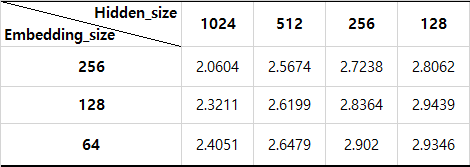


## 회고

> - 이미지 처리와 다르게 자연어의 전처리 과정은 목적에 맞게 토큰화 및 정제, 정규화 과정을 거쳐야 한다.
> - Embedding이란 사람의 언어(자연어)를 컴퓨터가 이해할 수 있게 수치화 해주는 과정을 뜻한다.
> - buffer_size값을 src_input의 길이와 같게 혹은 더 크게 줘야한다. 값을 작게 줄 경우, 몇 부분을 놓치고 셔플 할 수 있다.
> - embedding_size를 줄일수록 학습 속도가 느리다. hidden_size를 줄일수록 학습 속도가 빠르다.
> - embedding_size를 줄일수록 loss의 값이 증가 했지만 서서히 증가하는 모습을 보였다.
> - hidden_size를 줄일수록, embedding과 마찬가지고 loss가 증가했지만 상대적으로 많이 증가하는 모습을 보였다. loss에 영향이 더 큰 모습을 보였다.

## 자료 출처
 - 정제, 정규화, 토큰화 : <https://wikidocs.net/21698>
 - pad_sequences : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
 - Embedding : https://simpling.tistory.com/1
 - LSTM : http://www.incodom.kr/LSTM
 - Dense : https://ssongnote.tistory.com/13
 - Hidden layer : https://www.techopedia.com/definition/33264/hidden-layer-neural-networks
 - imbedding size : https://algopoolja.tistory.com/34
 - hidden size : https://wikidocs.net/22886